## Download and setup project and data

In [1]:
!pip -q install openai-clip
!pip -q install gdown

In [2]:
!git clone 'https://github.com/ararchieves/house.git'
%cd house

Cloning into 'house'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 5.03 MiB | 11.79 MiB/s, done.
/kaggle/working/house


In [3]:
import gdown
data_link = 'https://drive.google.com/file/d/1-zD25r3PPt4fDJBPKbFy6Qdemeo039lG/view?usp=sharing' 
gdown.download(url=data_link, output='data_cat.zip', quiet=False, fuzzy=True)

print("Unzipping data")
!unzip -q 'data_cat' -d '.'
!mv 'data_cat' 'data'
!rm 'data_cat.zip'
print("Data Unzipping Complete!")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-zD25r3PPt4fDJBPKbFy6Qdemeo039lG
From (redirected): https://drive.google.com/uc?id=1-zD25r3PPt4fDJBPKbFy6Qdemeo039lG&confirm=t&uuid=42c5af6f-f5bd-49f2-aaa6-cf651ccf20ee
To: /kaggle/working/house/data_cat.zip
100%|██████████| 2.65G/2.65G [00:10<00:00, 241MB/s]


Unzipping data
Data Unzipping Complete!


## Code

## Imports

In [4]:
import os
import yaml
import random

from models.clipseg import CLIPDensePredT

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Config Variables

In [5]:
# Data
ROOT_DIR = './data'
BATCH_SIZE = 8
TRANSFORMS = None
SHUFFLE = True
SEED = 42
NUM_WORKERS = 0
PIN_MEMORY = True
# Training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3
EPOCHS = 15


## Data Loading and Visualization

In [6]:
class ChineseCityDataset(Dataset):
    def __init__(self, root_dir='./data' ,split='train', transform=None):
        super().__init__()

        if split == 'train':
            self.base_dir = f'{root_dir}/train'
        elif split == 'test':
            self.base_dir = f'{root_dir}/test'
        elif split == 'val':
            self.base_dir = f'{root_dir}/val'
        else:
            raise Exception(f"Invalid split parameter! '{split}' not in ['train', 'test', 'val']")

        # variables
        self.image_dir = f'{self.base_dir}/images'
        self.masks_dir = f'{self.base_dir}/masks'

        self.images = os.listdir(self.image_dir)
        self.mask_dirs = os.listdir(self.masks_dir)

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]

        img = read_image(f'{self.base_dir}/images/{image_name}', mode=ImageReadMode.RGB) / 255

        # Remove the view id from the image name: Image Name = {image_id}_{view}
        masks_dir_id = image_name.split('_')[0]

        # Masks info
        ## 0 = Ground Floor: 0
        ## 1-4 =  Short Building or a house: 1
        ## 5-10 = Meduim Building: 2
        ## 11+ = Tall Building: 3

        masks = []
        for mask_number in range(4):
            mask = read_image(f'{self.masks_dir}/{masks_dir_id}/{mask_number}.png', mode=ImageReadMode.GRAY) / 255
            masks.append(mask)


        if self.transform:
            img = self.transform(img)
            masks = [self.transform(mask) for mask in masks]

        return img, masks

In [7]:
train_data = ChineseCityDataset(root_dir=ROOT_DIR, split='train')
trainloader = DataLoader(train_data,
                         batch_size=BATCH_SIZE,
                         shuffle=SHUFFLE,
                         generator=torch.Generator().manual_seed(SEED),
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY
                         )

In [8]:
images, [mask0, mask1, mask2, mask3] = next(iter(trainloader))

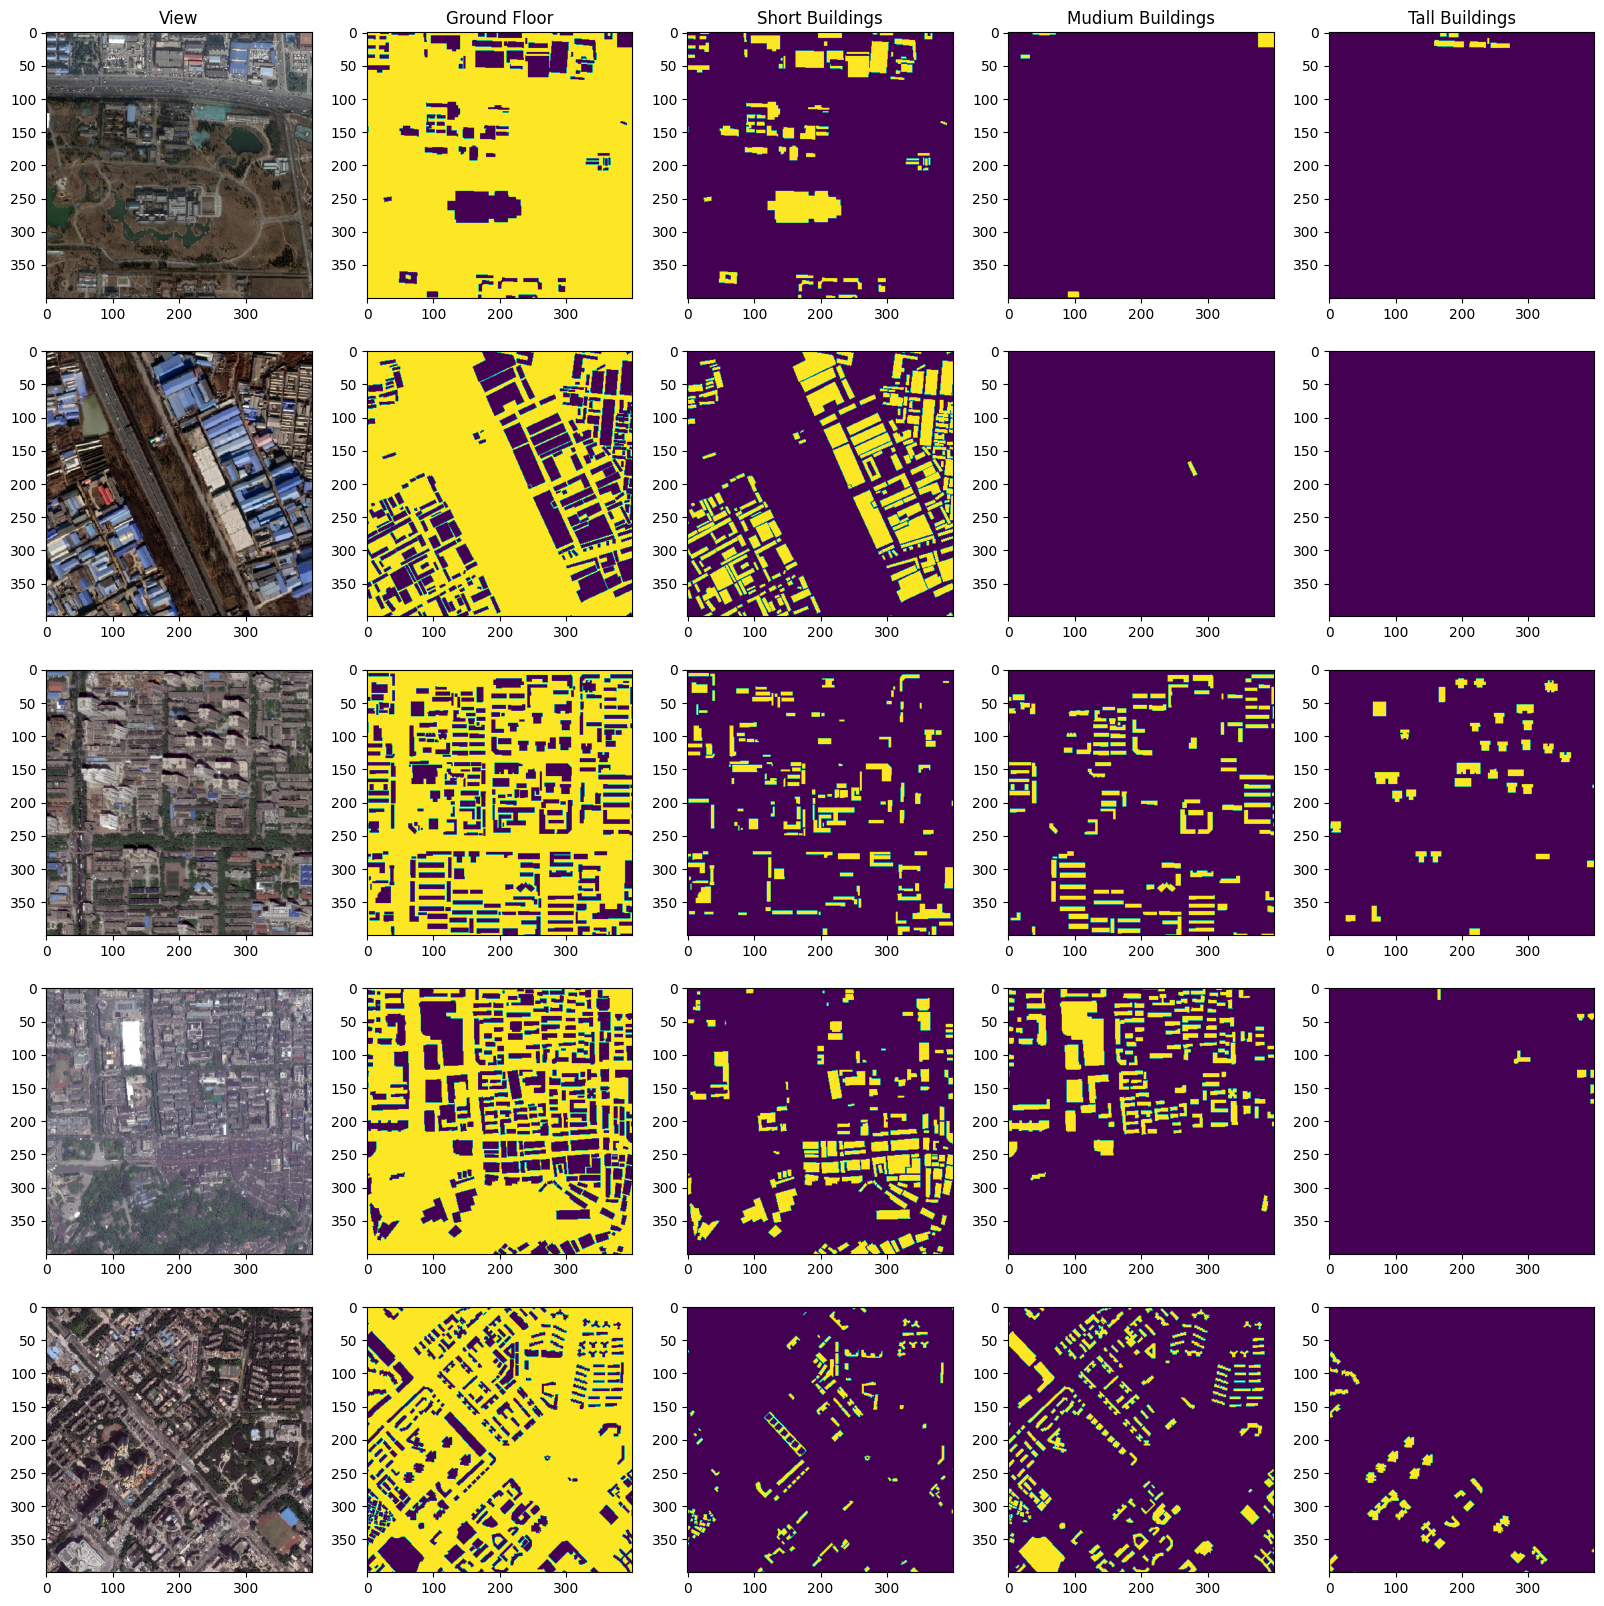

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

axes[0,0].set_title("View")
axes[0,1].set_title("Ground Floor")
axes[0,2].set_title("Short Buildings")
axes[0,3].set_title("Mudium Buildings")
axes[0,4].set_title("Tall Buildings")

for idx in range(5):
    axes[idx, 0].imshow(images[idx].permute(1,2,0))
    axes[idx, 1].imshow(mask0[idx].permute(1,2,0))
    axes[idx, 2].imshow(mask1[idx].permute(1,2,0))
    axes[idx, 3].imshow(mask2[idx].permute(1,2,0))
    axes[idx, 4].imshow(mask3[idx].permute(1,2,0))

plt.show()

## Training Setup 

In [10]:
model = CLIPDensePredT(version='ViT-B/16', complex_trans_conv=True).to(DEVICE)

100%|███████████████████████████████████████| 335M/335M [00:06<00:00, 56.7MiB/s]


In [11]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters are: {trainable_params:,}")

Total number of trainable parameters are: 2,583,873


In [12]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [13]:
with open(f'config/prompts.yaml', 'r') as f:
    _prompts = yaml.safe_load(f)


def get_random_prompts(mask_type, n_prompts, prompts=_prompts):
    valid_mask_types = [0,1,2,3]
    assert mask_type in valid_mask_types, f"Invalid mask_type! {mask_type} not in {valid_mask_types}"

    key_list = ["PromptsMask0", "PromptsMask1", "PromptsMask2", "PromptsMask3"]

    random_prompts = []
    for i in range(n_prompts):
        random_prompt = random.choice(prompts[key_list[mask_type]])
        random_prompts.append(random_prompt)

    return random_prompts


In [14]:
loss_list = []
loss_list_ext = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for idx, (images, masks) in tqdm(enumerate(trainloader), total=len(trainloader), desc=f'Epoch {epoch+1}/{EPOCHS}: '):
        images = images.to(DEVICE)
        masks = [mask.to(DEVICE) for mask in masks]

        # Prepare the images and masks for forward pass
        _images = images.repeat(4, 1, 1, 1)
        _masks = torch.cat(masks, dim=0)
        _prompts = []
        for i in range(4):
            _prompts += get_random_prompts(i, images.shape[0])

        optimizer.zero_grad()

        pred_mask = model(_images, _prompts)[0]
        loss = criterion(pred_mask, _masks)

        loss.backward()
        optimizer.step()


        epoch_loss += loss.item()
        loss_list_ext.append(loss.item())

    print(f"Loss: {epoch_loss:.4f}.")

    loss_list.append(epoch_loss)


Epoch 1/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 65.7501.


Epoch 2/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 57.8031.


Epoch 3/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 55.4687.


Epoch 4/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 54.1034.


Epoch 5/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 53.0731.


Epoch 6/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 52.2123.


Epoch 7/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 51.4766.


Epoch 8/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 50.8815.


Epoch 9/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 50.2879.


Epoch 10/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 49.8449.


Epoch 11/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 49.3926.


Epoch 12/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 48.9914.


Epoch 13/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 48.5600.


Epoch 14/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 48.0290.


Epoch 15/15:   0%|          | 0/769 [00:00<?, ?it/s]

Loss: 47.6980.


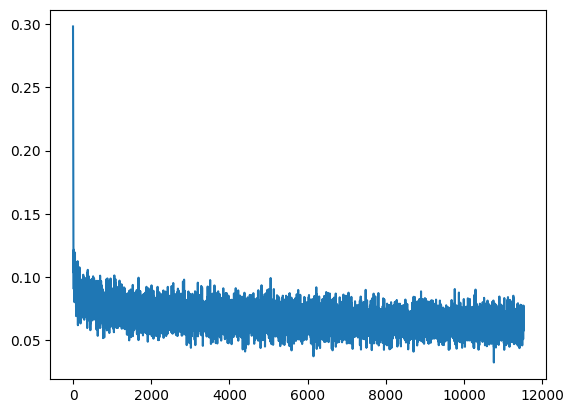

In [15]:
plt.plot(loss_list_ext)

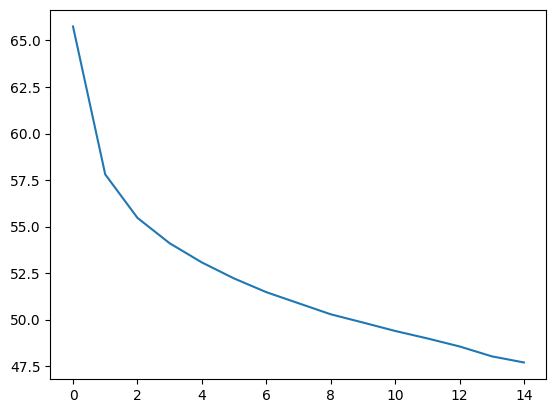

In [16]:
plt.plot(loss_list)

In [17]:
torch.save(model.state_dict(), "trained_model.pth")